In [2]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import cv2
import PIL
import matplotlib.pyplot as plt
import PySimpleGUI as sg 
import numpy as np

imsize = 256

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

Using TensorFlow backend.


In [ ]:
X = []
arr = []
narr = []
for filename in os.listdir('FaceTrain2/'):
    arr = img_to_array(load_img('FaceTrain2/'+filename))
    narr = cv2.resize(arr, (imsize,imsize))
    X.append(narr)
X = np.array(X, dtype = 'float')

split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [3]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

model.load_weights("newfacemodel.h5")

#model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop', metrics=['mse'])
model.compile(optimizer='rmsprop', loss='mse')
print("Weights Loaded")

Weights Loaded


In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

batch_size = 19
def image_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model
tensorboard = TensorBoard(log_dir="log/graph")
model.fit_generator(image_gen(batch_size), callbacks=[tensorboard], epochs=50, steps_per_epoch=50)

In [ ]:
model.save_weights("newlogfacemodel.h5")

In [ ]:
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

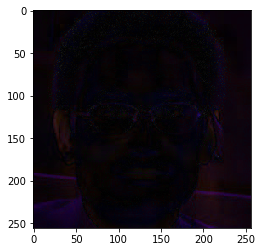

0.4117647058823529
0.030773327397365196
0.023529411764705882


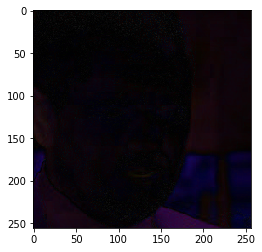

0.3333333333333333
0.03158112569572099
0.0196078431372549


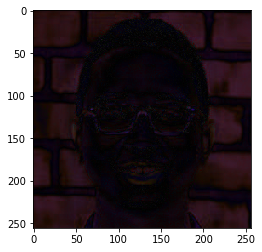

0.4196078431372549
0.05546547883476308
0.0392156862745098


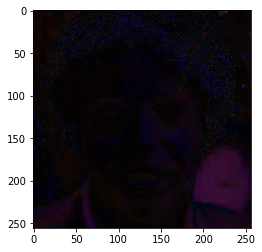

0.4823529411764706
0.03795632755055147
0.023529411764705882


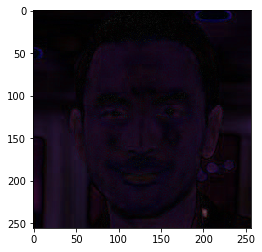

0.47058823529411764
0.05067553551368462
0.0392156862745098


In [15]:
color_me = []
arr = []
narr = []

for filename in os.listdir('Test/'):
    arr = img_to_array(load_img('Test/'+filename))
    narr = cv2.resize(arr, (imsize,imsize))
    color_me.append(narr)
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((imsize,imsize, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("res/img_"+str(i)+".jpg", lab2rgb(cur))
    
i = 0
for image in os.listdir('Test/'):
    col = img_to_array(load_img('Test/'+image))
    cnn = img_to_array(load_img('res/img_' + str(i) + '.jpg'))
    ls = abs(col - cnn)
    ls = np.array(ls, dtype='float')
    ls = ls / 255
    plt.imshow(ls)
    plt.show()
    print(np.max(ls))
    print(np.mean(ls))
    print(np.median(ls))
    i = i + 1

    